In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
from dune.generator import builder
import math
import numpy as np
import scipy.sparse.linalg
import scipy.optimize
import dune.grid
import dune.fem
from dune.fem.plotting import plotPointData as plot
import dune.create as create

from dune.ufl import Space
from ufl import TestFunction, TrialFunction, SpatialCoordinate, ds, dx, inner, grad

grid = create.grid("ALUConform", dune.grid.cartesianDomain([0, 0], [1, 1], [8, 8]), dimgrid=2)
spc = create.space("lagrange", grid, dimrange=1, order=1, storage='fem')

d = 0.001
p = 1.7

uflSpace = Space(spc)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())

rhs = (x[0] + x[1]) * v[0]
a = (pow(d + inner(grad(u), grad(u)), (p-2)/2)*inner(grad(u), grad(v)) \
    + inner(u, v)) * dx + 10*inner(u, v) * ds
b = rhs * dx + 10*rhs * ds

scheme = create.scheme("h1", spc, a == b, \
       parameters=\
       {"fem.solver.newton.linabstol": 1e-10,
        "fem.solver.newton.linreduction": 1e-10,
        "fem.solver.newton.verbose": 1,
        "fem.solver.newton.linear.verbose": 0})

# create a discrete solution over this space - will be initialized with zero by default
uh = create.function("discrete", spc, name="solution")

In the following we implement a simple Newton solver: given an initial guess $u^0$ (here taken to be zero) solve for $n\geq 0$.
\begin{align*}
   u^{n+1} = u^n - DS(u^n)(S(u^n)-g)
\end{align*}
Where $g$ is a discrete function containing the boundary values in the Dirichlet nodes and zero otherwise.

Usually this would be automatically taken care of in Fempy by `scheme.solve`, however this time we will use the call operator on the `scheme` to compute $S(u^n)$ as well as `scheme.assemble` to get a copy of the system matrix in form of a SciPy sparse row matrix. Note that this method is not available for all storage types.

iterations (0) 8.204874174739299
iterations (1) 0.7706154521999533
iterations (2) 0.005643744976839006
iterations (3) 2.3213588581809258e-06
iterations (4) 5.45734062602357e-13


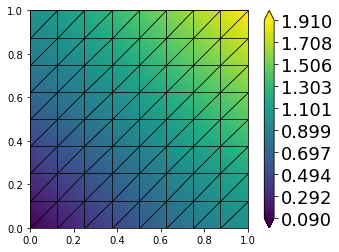

In [3]:
# create a copy of uh for the residual
res = uh.copy() 

# create numpy vectors to store uh and res
sol_coeff = uh.as_numpy
res_coeff = res.as_numpy
n = 0

while True:
    scheme(uh, res)
    absF = math.sqrt( np.dot(res_coeff,res_coeff) )
    print("iterations ("+str(n)+")",absF)
    if absF < 1e-10:
        break
    matrix = scheme.assemble(uh)
    sol_coeff -= scipy.sparse.linalg.spsolve(matrix, res_coeff)
    n += 1

plot(uh)

We can redo the above computation but now use the Newton solver available in SciPy.

0:  |F(x)| = 0.770615; step 1; tol 0.00793915
1:  |F(x)| = 0.00564375; step 1; tol 4.82727e-05
2:  |F(x)| = 2.32135e-06; step 1; tol 1.52261e-07
3:  |F(x)| = 5.50494e-13; step 1; tol 5.06137e-14


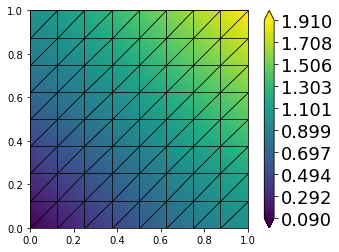

In [4]:
# let's first set the solution back to zero - since it already contains the right values
uh.clear()
def f(x_coeff):
    x = spc.numpyFunction(x_coeff, "tmp")
    scheme(x,res)
    return res_coeff
# class for the derivative DS of S
class Df(scipy.sparse.linalg.LinearOperator):
    def __init__(self,x_coeff):
        self.shape = (sol_coeff.shape[0],sol_coeff.shape[0])
        self.dtype = sol_coeff.dtype
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = spc.numpyFunction(x_coeff, "tmp")
        # store the assembled matrix
        self.jac = scheme.assemble(x)
    # reassemble the matrix DF(u) gmiven a dof vector for u
    def update(self,x_coeff,f):
        x = spc.numpyFunction(x_coeff, "tmp")
        # Note: the following does produce a copy of the matrix
        # and each call here will reproduce the full matrix
        # structure - no reuse possible in this version
        self.jac = scheme.assemble(x)
    # compute DS(u)^{-1}x for a given dof vector x
    def _matvec(self,x_coeff):
        return scipy.sparse.linalg.spsolve(self.jac, x_coeff)

# call the newton krylov solver from scipy
sol_coeff[:] = scipy.optimize.newton_krylov(f, sol_coeff,
            verbose=1, f_tol=1e-8,
            inner_M=Df(sol_coeff))

plot(uh)